### Quick pass at Survival Analysis, see lowest cells.  There is a difference between longevity by gender, and apparently for married/unmarried (though it switches -- married men live longer than unmarried, while the reverse is true for women!)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/nhis.csv", index_col=0)

We'll be doing a classic survival analysis model, using Cox PH to look at sex differences in time to death (aka. longevity) using data from the U.S. National Health Interview Survey. This data is particularly great because they have both year of birth and year of death. Death records stop in 2009 (when the dataset was considered complete), so any people who are still living in 2009 will need to be right-censored.

Some people do not have date of birth. Those cases will be truncated.

Let's start by loading the data, taking a look at it, and cleaning it up:

In [3]:
print(data.shape)
data.head()

(1605246, 9)


,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY
2744230,1986,1986109602890101,60,1,NaN,11,NaN,1.0,2005.0
2744231,1986,1986109602890102,54,2,NaN,11,NaN,1.0,2010.0
2744232,1986,1986109602890103,21,1,NaN,50,NaN,2.0,9999.0
2744233,1986,1986109602890201,46,1,NaN,11,NaN,2.0,9999.0
2744234,1986,1986109602890202,38,2,NaN,11,NaN,2.0,9999.0


In [4]:
# Looks like this whole column is empty, drop it (in next cell)
data[data['SEXORIEN'].notnull()]

,YEAR,NHISPID,AGE,SEX,SEXORIEN,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY


In [5]:
data.drop('SEXORIEN', axis=1, inplace=True)
data.head()

,YEAR,NHISPID,AGE,SEX,MARSTAT,BIRTHYR,MORTSTAT,MORTDODY
2744230,1986,1986109602890101,60,1,11,NaN,1.0,2005.0
2744231,1986,1986109602890102,54,2,11,NaN,1.0,2010.0
2744232,1986,1986109602890103,21,1,50,NaN,2.0,9999.0
2744233,1986,1986109602890201,46,1,11,NaN,2.0,9999.0
2744234,1986,1986109602890202,38,2,11,NaN,2.0,9999.0


In [6]:
data.dtypes

YEAR          int64
NHISPID       int64
AGE           int64
SEX           int64
MARSTAT       int64
BIRTHYR     float64
MORTSTAT    float64
MORTDODY    float64
dtype: object

In [7]:
# Dropping cases where birth year is not known
data2 = data[(data["BIRTHYR"] <= 2009) & (data["BIRTHYR"].notnull())]

# Calculating time-to-event
data2["Longevity"] = data2["MORTDODY"] - data2["BIRTHYR"]

# Creating a 'status' variable where 1 means dead and 0 means alive as of 2009
data2["dead"] = (2 - data2['MORTSTAT'])

# For people who were alive as of 2009, calculating their longevity as their age in 2009
data2.loc[data2['dead'] == 0, "Longevity"] = 2009 - data2.loc[data2['dead'] == 0, "BIRTHYR"] 

# Creating a binary variable where 1 = female and 0 = male
data2["female"] = (data2["SEX"] == 2)

# Now these columns are duplicated, drop them
data2.drop(columns=['SEX', 'MORTSTAT'], inplace=True)

# Change all datatypes to int
data2 = data2.astype(int)

In [8]:
print(data2.shape)
data2.head()

(754219, 9)


,YEAR,NHISPID,AGE,MARSTAT,BIRTHYR,MORTDODY,Longevity,dead,female
3928174,1997,19970003080101,33,11,1963,9999,46,0,1
3928175,1997,19970003080102,36,11,1960,9999,49,0,0
3928178,1997,19970003090101,42,11,1954,1999,45,1,0
3928179,1997,19970003090102,52,11,1944,9999,65,0,1
3928182,1997,19970003100101,41,11,1955,9999,54,0,0


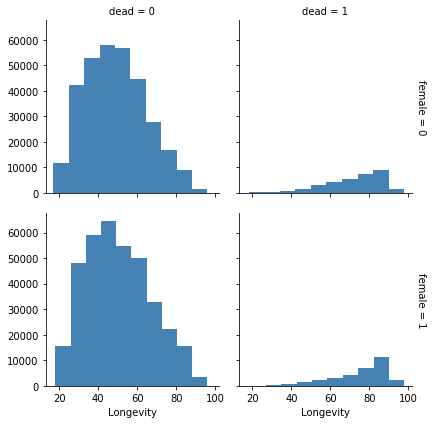

In [9]:
g = sns.FacetGrid(data2, row="female", col="dead", margin_titles=True)
g.map(plt.hist, "Longevity", color="steelblue", lw=0)
plt.show()

### The first look
After data cleaning, we've gone from 1605246 records to 754219. The vast majority of our sample was still living as of 2009. This means most of our data will be right-censored.

Now we're going to use the statsmodels survival analysis functions to create some models for our data. First, we can calculate the Hazard (risk of death) for each age, starting at the youngest people in the sample (18 years old in 2009).

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

sf = sm.SurvfuncRight(data2["Longevity"], data2["dead"])
sf.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
18,0.999997,0.000002,754217,2.0
19,0.999981,0.000005,753439,12.0
20,0.999940,0.000009,751911,31.0
21,0.999879,0.000013,749414,46.0
22,0.999825,0.000015,746169,40.0


You can notice a few things in the survival table:

- First, only 2 people in the sample died at the age of 18, with the number of deaths increasing after that.
- Second, the standard error steadily gets larger as the sample size (the number at risk, aka. the number of people alive at that timepoint) shrinks.
- Finally, the 'number at risk' drops at each timepoint, but by quite a bit more than the number of deaths. This reflects our right-censoring. If someone turned 18 in 2009 and didn't die, they don't count toward the 'number at risk' at age 19 because they're out of the observation window, but they also aren't an event at timepoint 18 because they were still alive at that age.

We can also make a very nice survival plot for the men and the women:

(0.85, 1)

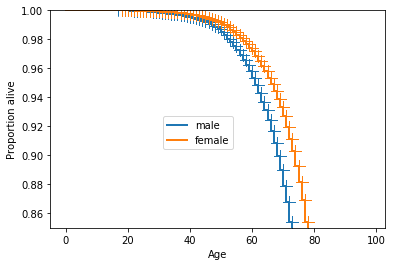

In [11]:
# Plot code modified from the statsmodels docs at http://www.statsmodels.org/dev/duration.html

groups = data2.groupby("female")
ax = plt.axes()
sexes = ["male", "female"]

# Fitting a survival function for each group
for group in groups:
    sf = sm.SurvfuncRight(group[1]["Longevity"], group[1]["dead"])
    sf.plot(ax)
li = ax.get_lines()
plt.figlegend((li[0], li[2]), sexes, "center")
ax.set_ylabel("Proportion alive")
ax.set_xlabel("Age")
ax.set_autoscaley_on(False)
ax.set_ylim([.85,1])

Most people are still alive, but this may be due to extreme right-censoring.

### Cox PH for gender
A graph is all very well, but is the difference in longevity for men and women meaningful? We can test using the Cox PH model.

In [12]:
# Model, Data, and if Right-Censored
mod = smf.phreg("Longevity ~  female", data2, status=data2['dead'].values) 
rslt = mod.fit()
print(rslt.summary())

                       Results: PHReg
Model:                  PH Reg        Sample size:     754217
Dependent variable:     Longevity     Num. events:     67383 
Ties:                   Breslow                              
-------------------------------------------------------------
        log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-------------------------------------------------------------
female -0.4460    0.0078 0.6402 -57.5296 0.0000 0.6306 0.6500
Confidence intervals are for the hazard ratios


It looks like the difference is meaningful. The convention is to report and interpret the Hazard Ratio (HR) rather than the log HR. According to the Cox PH, at any given age, women are 64% less likely to die than men, with a 95% confidence interval of 63% to 65%. This difference is statistically significant at  𝛼  of .05 (p < .0001). Our confidence interval is tiny because our sample is so big!

Looking from the plot to the model, you may notice that the data tell a slightly different story. The survival rate discrepancy seems to shrink a bit after age 80. This suggests that either we should include some additional features in the model to try and account for this discrepancy, or we should use a different modeling technique that doesn't assume that the effects of features are consistent across all values.

We can plot the predicted survival rates from the model:

In [13]:
data2["predicted"] = rslt.predict(pred_type='surv').predicted_values
print(data2.head())

         YEAR         NHISPID  AGE  MARSTAT  BIRTHYR  MORTDODY  Longevity  \
3928174  1997  19970003080101   33       11     1963      9999         46   
3928175  1997  19970003080102   36       11     1960      9999         49   
3928178  1997  19970003090101   42       11     1954      1999         45   
3928179  1997  19970003090102   52       11     1944      9999         65   
3928182  1997  19970003100101   41       11     1955      9999         54   

         dead  female  predicted  
3928174     0       1   0.994803  
3928175     0       0   0.988401  
3928178     1       0   0.992777  
3928179     0       1   0.956459  
3928182     0       0   0.978739  


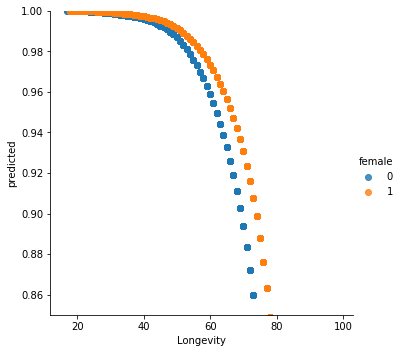

In [14]:
sns.lmplot(x="Longevity", y="predicted", hue="female", data=data2, fit_reg=False, lowess=True)
plt.ylim(.85, 1)
plt.show()

Going back to the survival rates from the raw data, it does appear this model is missing some elements, including the shrinkage in the gender difference after 80, but also the leveling-off of the survival rate once people get to 90 years or older. Again, adding more parameters may help.

## Drill
They say that people who get married live longer than people who don't. Test that assertion by using marital status as an additional feature in your model. You'll need to create a feature that differentiates the never married from everyone else - check the codebook to get started. Does marriage make a difference? Calculate the survival plot and the hazard ratio for being married at any point a lifetime.

Marital status is as follows (found in codebook online):
- 10: Married
- 11: Married - Spouse Present
- 12: Married - Spouse not in Household
- 13: Married - Spouse in Household Unknown
- 20: Widowed
- 30: Divorced
- 40: Separated
- 50: Never Married
- 99: Unknown

In [15]:
print(f"{data2.shape[0]} rows in the data")
data2['MARSTAT'].value_counts()

754219 rows in the data


11    251130
10    180579
50    170198
30     74561
20     49623
40     19796
12      5602
99      2722
13         8
Name: MARSTAT, dtype: int64

### Make some decisions about what to keep
I think the 'Unknown' category should be dropped, as it gives us no information at all, and is roughly 0.33% of our overall dataset.  I'm also dropping the 8 who are married but 'Spouse in Household Unknown'.  I'm not sure what that means, and again it's a very small part of the data.

Exploration can be made of the other categories; it's likely that being widowed, divorced, or separated has an impact on longevity that's different than those who are married.  For now we'll stick with never married and everything else.

In [16]:
data2 = data2[(data2['MARSTAT'] != 99) & (data2['MARSTAT'] != 13)]
print(f"{data2.shape[0]} rows in the data")
data2['MARSTAT'].value_counts()

751489 rows in the data


11    251130
10    180579
50    170198
30     74561
20     49623
40     19796
12      5602
Name: MARSTAT, dtype: int64

In [17]:
# Feature for never married
data2['unmarried'] = np.where((data2['MARSTAT'] == 50), 1, 0)
data2.head()

,YEAR,NHISPID,AGE,MARSTAT,BIRTHYR,MORTDODY,Longevity,dead,female,predicted,unmarried
3928174,1997,19970003080101,33,11,1963,9999,46,0,1,0.994803,0
3928175,1997,19970003080102,36,11,1960,9999,49,0,0,0.988401,0
3928178,1997,19970003090101,42,11,1954,1999,45,1,0,0.992777,0
3928179,1997,19970003090102,52,11,1944,9999,65,0,1,0.956459,0
3928182,1997,19970003100101,41,11,1955,9999,54,0,0,0.978739,0


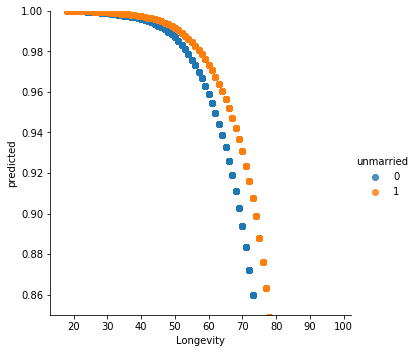

In [32]:
df = data2[(data2['female'] == 0) & data2['unmarried'] == 0]

sns.lmplot(x="Longevity", y="predicted", hue="unmarried",
           data=df, fit_reg=False, lowess=True, sharex=False)
plt.ylim(.85, 1)
plt.show()

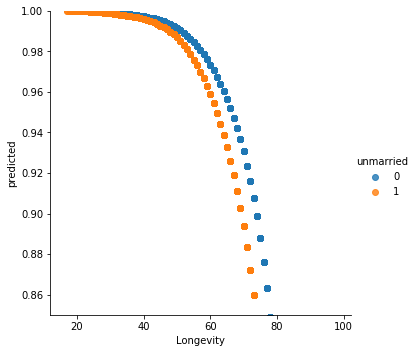

In [33]:
df1 = data2[(data2['female'] == 1) & data2['unmarried'] == 0]

sns.lmplot(x="Longevity", y="predicted", hue="unmarried",
           data=df1, fit_reg=False, lowess=True, sharex=False)
plt.ylim(.85, 1)
plt.show()

### Unmarried men MORE likely to die sooner
At a quick pass, you can see graphically and below: The Hazard Ratio for unmarried men vs. married is 67%

In [34]:
# Model, Data, and if Right-Censored
mod = smf.phreg("Longevity ~  female", df, status=df['dead'].values) 
rslt = mod.fit()
print(rslt.summary())

                       Results: PHReg
Model:                  PH Reg        Sample size:     662968
Dependent variable:     Longevity     Num. events:     63911 
Ties:                   Breslow                              
-------------------------------------------------------------
        log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-------------------------------------------------------------
female -0.3947    0.0080 0.6739 -49.5925 0.0000 0.6635 0.6845
Confidence intervals are for the hazard ratios


### Married women MORE likely to die sooner
And, shocker, being married to men makes women die sooner!!!  Looks like 62%

In [35]:
# Model, Data, and if Right-Censored
mod = smf.phreg("Longevity ~  female", df1, status=df1['dead'].values) 
rslt = mod.fit()
print(rslt.summary())

                       Results: PHReg
Model:                  PH Reg        Sample size:     669438
Dependent variable:     Longevity     Num. events:     64770 
Ties:                   Breslow                              
-------------------------------------------------------------
        log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-------------------------------------------------------------
female -0.4781    0.0079 0.6200 -60.3689 0.0000 0.6104 0.6297
Confidence intervals are for the hazard ratios
